# Geospatial analysis of heart disease
---

*Code made by [Diego Oliveira](https://github.com/@you)

In [1]:
# def norm(df):
#     z_m = list(df['Z-SCORE'])
#     z_r = list(df['Z-SCORE-R'])
#     z = z_m+z_r
#     z_min = min(z)
#     z_max = max(z)
    
#     df['Z-SCORE']   = df['Z-SCORE'].apply(lambda x: (x - z_min)/(z_max - z_min)) 
#     df['Z-SCORE-R'] = df['Z-SCORE-R'].apply(lambda x: (x - z_min)/(z_max - z_min)) 
    
#     return(df)

# def norm2(df):
#     z_m = list(df['Z-SCORE'])
#     z = z_m
#     z_min = min(z)
#     z_max = max(z)
    
#     df['Z-SCORE']   = df['Z-SCORE'].apply(lambda x: (x - z_min)/(z_max - z_min))    
#     return(df)



### Import required libraries

In [2]:
# IMPORT CONFIGs
import os
import sys
sys.path.insert(0, '../')
sys.path.insert(0, '../scripts')
from config import RAW_PATH, TREAT_PATH, OUTPUT_PATH


# DATA ANALYSIS & VIZ TOOLR
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


import pandas as pd
import geopandas as gpd
pd.options.display.max_columns = 999

#import plotly
#import plotly.graph_objs as go
#import plotly.offline as offline
#offline.init_notebook_mode(connected=True)
import json
import warnings
warnings.filterwarnings('ignore')

### Import data

In [24]:
df_dci = pd.read_excel('{}/DIC Z-Scores Taxas padronizadas Pop Total Municípios v2.xlsx'.format(RAW_PATH))
df_iam = pd.read_excel('{}/IAM Z-Scores Taxas padronizadas Pop Total Municípios v2.xlsx'.format(RAW_PATH))

df_dci_r = pd.read_excel('{}/DIC Z-Scores Taxas padronizadas Pop Total Região de Saúde.xlsx'.format(RAW_PATH))
df_iam_r = pd.read_excel('{}/IAM Z-Scores Taxas padronizadas Pop Total Região de Saúde.xlsx'.format(RAW_PATH))



df_cod = pd.read_excel('{}/CodigosDosMunicipios_original.xls'.format(RAW_PATH))

df_dict = pd.read_excel('{}/obt.xlsx'.format(RAW_PATH))

In [25]:
rename_dic = {
    'Ç':'C',
    'BRODOSQUI'            :'BRODOWSKI',
    'IPAUSSU'              :'IPAUCU',
    'MOGI GUACU'           :'MOGI-GUACU',
    'MOJI MIRIM'           :'MOGI-MIRIM',
    'SANTA ROSA DE VITERBO':'SANTA ROSA DO VITERBO',
    'SANTANA DE PARNAIBA'  :'SANTANA DO PARNAIBA',
    'EMBU DAS ARTES':'EMBU'
    
}

df_dci['Município'] = df_dci['MUNICÍPIO'].str.replace('[\d]', '').str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.strip().str.upper()
df_dci['Município'] = df_dci['Município'].replace(rename_dic)

df_iam['Município'] = df_iam['MUNICÍPIO'].str.replace('[\d]', '').str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.strip().str.upper()
df_iam['Município'] = df_iam['Município'].replace(rename_dic)


cols = ['RRAS','DEPARTAMENTO REGIONAL DE SAÚDE','REGIÃO DE SAÚDE','Município']
df_dict = df_dict[cols]
df_dict['Município'] = df_dict['Município'].str.replace('[\d]', '').str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.strip().str.upper()
df_dict['Município'] = df_dict['Município'].replace(rename_dic)





df_cod['Município'] = df_cod['Município'].str.replace('[\d]', '').str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.strip().str.upper()
df_cod = df_cod.rename(columns={'Código do Município':'id'})
df_cod['id'] = df_cod['id'].astype(int)
df_cod['Município'] = df_cod['Município'].replace(rename_dic)





cols = ['REGIÃO DE SAÚDE','ANO','Z-SCORE']
df_dci_r = df_dci_r[cols]
df_iam_r = df_iam_r[cols]

df_dci_r = df_dci_r.rename(columns={'Z-SCORE':'Z-SCORE-R'})
df_iam_r = df_iam_r.rename(columns={'Z-SCORE':'Z-SCORE-R'})

Geodata BR - Brazil
===================

[This project](https://github.com/tbrugz/geodata-br) contains files [Geojson](http://geojson.org/) with the perimeters
of brazilian municipalities grouped by state.

### Região Sudeste
* SP / São Paulo - [geojson/geojs-35-mun.json](geojson/geojs-35-mun.json)



In [26]:
df_maps = gpd.read_file('{}/sp.json'.format(RAW_PATH))
df_maps['id'] = df_maps['id'].astype(int)

In [27]:
#merge codes with polygons
df_merge_ = pd.merge(df_cod,df_maps, how='left', on=['id'] )

In [28]:
#merge codes polygons and RRAS 
df_merge = pd.merge(df_dict,df_merge_, how='right', on=['Município'] )

In [29]:
#merge all others with zscores
df_final_dci = pd.merge(df_dci,df_merge, how='left', on=['Município'])
df_final_iam = pd.merge(df_iam,df_merge, how='left', on=['Município'])

cols = ['RRAS', 'DEPARTAMENTO REGIONAL DE SAÚDE','REGIÃO DE SAÚDE','Município','ANO','TAXA PAD WHO POP TOTAL','SE TAXA PAD WHO POP TOTAL','Mean(TAXA PAD WHO POP TOTAL)','Mean(SE TAXA PAD WHO POP TOTAL)','Z-SCORE','geometry']
df_plot_dci = df_final_dci[cols]
df_plot_iam = df_final_iam[cols]



df_plot_dci = gpd.GeoDataFrame(df_plot_dci)
df_plot_iam = gpd.GeoDataFrame(df_plot_iam)


df_plot_dci = pd.merge(df_plot_dci,df_dci_r, how='left', on=['REGIÃO DE SAÚDE','ANO'])
df_plot_iam = pd.merge(df_plot_iam,df_iam_r, how='left', on=['REGIÃO DE SAÚDE','ANO'])

In [30]:
def plt_map(df, title='DCI',RRAS = False, RRS = False, colors=['viridis'], fix_scale=True):
    
    
#     if normalize == True:
#         df = norm(df_2)
#     else:RRAS 11	3511 PRESIDENTE PRUDENTE	35112 ALTA SOROCABANA

#         df = df_2
        
    min_z = min(df['Z-SCORE'])
    max_z = max(df['Z-SCORE'])
        
    years = df['ANO'].unique()
    rras  = df['RRAS'].unique()
    rrs   = df['REGIÃO DE SAÚDE'].unique()

    if RRAS == True:
        for year in years[:1]:
            for rra in rras[:3]:
                mask = (df['ANO'] == year) & (df['RRAS'] == rra)

                fig = plt.figure(figsize=(5,5))
                ax  = fig.add_subplot(1,1,1)
                ax.set_title('{} - {} - {}'.format(title,year, rra))
                divider = make_axes_locatable(ax)
                cax = divider.append_axes("right", size="5%", pad=0.1)
                df[mask].plot(column='Z-SCORE', ax=ax, legend=True, cax=cax)
                
                plt.tight_layout()
                
    elif RRS == True:
        for color in colors:
            for year in years[:1]:
                for rr in rrs[:1]:
                    mask = (df['ANO'] == year) & (df['REGIÃO DE SAÚDE'] == rr)
                    rr_value = df[mask]['Z-SCORE-R'].mean()
                    fig = plt.figure(figsize=(7,7))

                    ax  = fig.add_subplot(1,1,1)
                    ax.set_title('{} - {} - {} = {}    - cmap = {}'.format(title,year, rr,round(rr_value,2),color))
                    divider = make_axes_locatable(ax)
                    cax = divider.append_axes("right", size="5%", pad=0.1)
                    df[mask].plot(column='Z-SCORE'  , ax=ax, legend=True, cax=cax, cmap=color, vmin=min_z, vmax=max_z)

    #                 ax1  = fig.add_subplot(1,2,2)
    #                 divider = make_axes_locatable(ax1)
    #                 cax = divider.append_axes("right", size="5%", pad=0.1)
    #                 ax1.set_title('{} Municípios - {} - {}'.format(title,year, rr))
    #                 df[mask].plot(column='Z-SCORE-R', ax=ax1, legend=True, cax=cax)

                    plt.tight_layout()
                #   plt.savefig("{}.png".format('DCI - {}'.format(year)), dpi=150)
    else:
        for color in colors:
            for year in years[:1]:
                mask = (df['ANO'] == year)

                fig = plt.figure(figsize=(10,10))

                ax  = fig.add_subplot(1,1,1)
                ax.set_title('{} Municípios - {}'.format(title,year))
                divider = make_axes_locatable(ax)
                cax = divider.append_axes("right", size="5%", pad=0.1)

                if fix_scale == True:
                    df[mask].plot(column='Z-SCORE'  , ax=ax, legend=True, cax=cax, cmap=color, vmin=min_z, vmax=max_z)
                else:
                    df[mask].plot(column='Z-SCORE'  , ax=ax, legend=True, cax=cax, cmap=color)



    #             ax1  = fig.add_subplot(2,1,2)
    #             divider = make_axes_locatable(ax1)
    #             cax = divider.append_axes("right", size="5%", pad=0.1)
    #             ax1.set_title('{} Regoẽs- {}'.format(title,year))           
    #             df[mask].plot(column='Z-SCORE-R', ax=ax1, legend=True, cax=cax, cmap='viridis')


                plt.tight_layout()
#                 plt.savefig("{}.png".format('{} - {}'.format(title,year)), dpi=150)


In [31]:
cmaps = {'Perceptually Uniform Sequential': ['viridis', 'plasma', 'inferno', 'magma'],
         'Sequential'                     :['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds','YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu','GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'],
         'Sequential_2': ['binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink','spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia','hot', 'afmhot', 'gist_heat', 'copper'],
         'Diverging': ['PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu','RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic'],
         'Qualitative': ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c'],
         'Miscellaneous': ['flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern', 'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv','gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar']
        }

op = list(cmaps.keys())




In [32]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

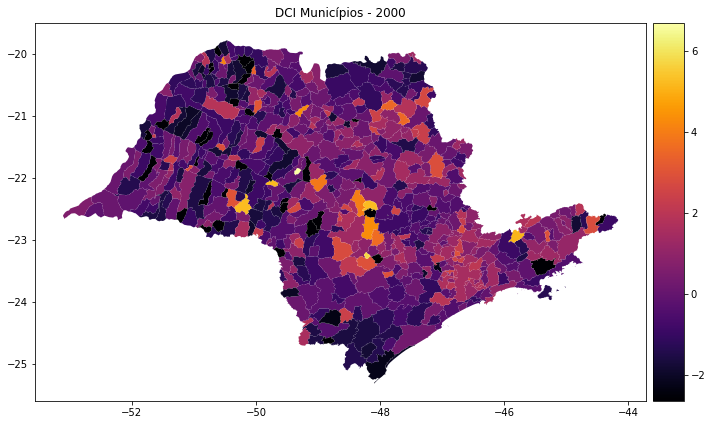

In [35]:
plt_map(df_plot_dci,title = 'DCI',RRS = False, colors = ['inferno'], fix_scale=False)

In [36]:
df_plot_dci['geometry'] = df_plot_dci.buffer(0.001) 

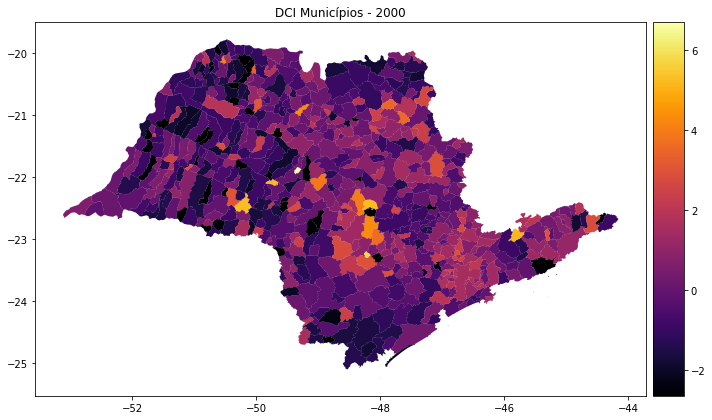

In [37]:
plt_map(df_plot_dci,title = 'DCI',RRS = False, colors = ['inferno'], fix_scale=False)

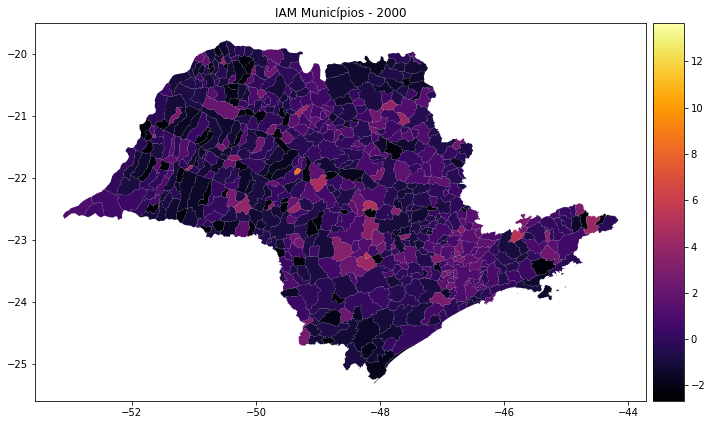

In [38]:
plt_map(df_plot_iam,title = 'IAM',RRS = False, colors = ['inferno'], fix_scale=True)

In [39]:
df_plot_iam.head()

,RRAS,DEPARTAMENTO REGIONAL DE SAÚDE,REGIÃO DE SAÚDE,Município,ANO,TAXA PAD WHO POP TOTAL,SE TAXA PAD WHO POP TOTAL,Mean(TAXA PAD WHO POP TOTAL),Mean(SE TAXA PAD WHO POP TOTAL),Z-SCORE,geometry,Z-SCORE-R
0,RRAS 10,3509 MARÍLIA,35091 ADAMANTINA,ADAMANTINA,2000,50.332021,11.865764,49.691727,21.213052,0.030184,"POLYGON ((-51.0578686748 -21.3988835488, -51.0...",-0.707746
1,RRAS 10,3509 MARÍLIA,35091 ADAMANTINA,ADAMANTINA,2001,43.161919,10.790480,48.809949,20.253613,-0.278865,"POLYGON ((-51.0578686748 -21.3988835488, -51.0...",-0.592483
2,RRAS 10,3509 MARÍLIA,35091 ADAMANTINA,ADAMANTINA,2002,47.545540,11.210366,48.295474,20.008435,-0.037481,"POLYGON ((-51.0578686748 -21.3988835488, -51.0...",-0.874580
3,RRAS 10,3509 MARÍLIA,35091 ADAMANTINA,ADAMANTINA,2003,54.017192,11.792699,48.778480,20.002895,0.261898,"POLYGON ((-51.0578686748 -21.3988835488, -51.0...",-0.820542
4,RRAS 10,3509 MARÍLIA,35091 ADAMANTINA,ADAMANTINA,2004,46.451303,10.973154,46.396615,18.500319,0.002956,"POLYGON ((-51.0578686748 -21.3988835488, -51.0...",-3.329940


In [40]:
df_plot_iam['geometry'] = df_plot_iam.buffer(0.000001) 

In [41]:
mask = (df_plot_iam['ANO'] == 2000)
df_rr = df_plot_iam[mask].reset_index(drop=True)

df_rs = df_rr.dissolve(by='REGIÃO DE SAÚDE')
df_rs = df_rs.reset_index()
cols = ['REGIÃO DE SAÚDE','DEPARTAMENTO REGIONAL DE SAÚDE' , 'RRAS', 'geometry']
df_rs = df_rs[cols]
df_rs['ID'] = df_rs['REGIÃO DE SAÚDE'].str.replace('[/\D+/g]', '')
df_rs['REGIÃO DE SAÚDE'] = df_rs['REGIÃO DE SAÚDE'].str.replace('[\d]', '')
cols = ['ID','REGIÃO DE SAÚDE','DEPARTAMENTO REGIONAL DE SAÚDE' , 'RRAS','geometry']
df_rs = df_rs[cols]


df_drs = df_rr.dissolve(by='DEPARTAMENTO REGIONAL DE SAÚDE')
df_drs = df_drs.reset_index()
cols = ['DEPARTAMENTO REGIONAL DE SAÚDE', 'geometry']
df_drs = df_drs[cols]
df_drs['ID'] = df_drs['DEPARTAMENTO REGIONAL DE SAÚDE'].str.replace('[/\D+/g]', '')
df_drs['DEPARTAMENTO REGIONAL DE SAÚDE'] = df_drs['DEPARTAMENTO REGIONAL DE SAÚDE'].str.replace('[\d]', '')
cols = ['ID','DEPARTAMENTO REGIONAL DE SAÚDE','geometry']
df_drs = df_drs[cols]


df_rras = df_rr.dissolve(by='RRAS')
df_rras = df_rras.reset_index()
cols = ['RRAS', 'geometry']
df_rras = df_rras[cols]



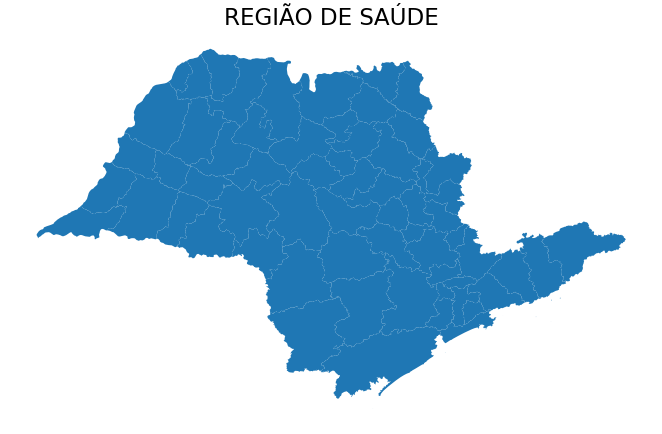

In [42]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.set_title('REGIÃO DE SAÚDE',fontsize=23)
df_rs.plot(ax = ax)
# ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)


<img src="https://images.slideplayer.com.br/1/292602/slides/slide_4.jpg" width="600" height="600" />

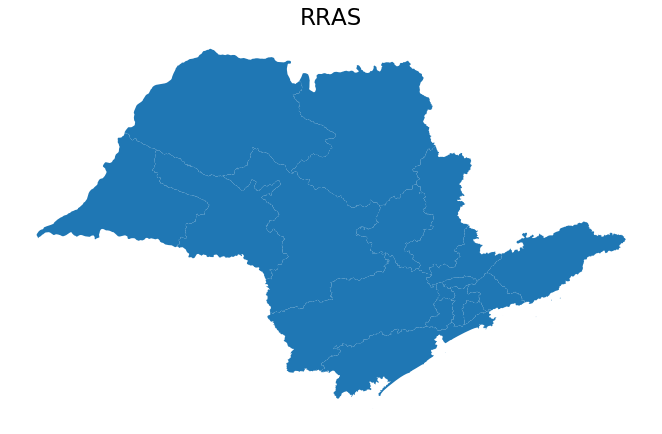

In [43]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.set_title('RRAS',fontsize=23)

df_rras.plot(ax = ax)
# ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

<img src="http://www.saude.sp.gov.br/resources/ces/homepage/rras/estado_rras_drs_rs_2012_dpi_300.jpg" width="600" height="600" />

In [44]:
df_rras.head()

,RRAS,geometry
0,RRAS 01,POLYGON ((-46.40998641435213 -23.8148528198692...
1,RRAS 02,POLYGON ((-45.96146250967615 -23.4965595185349...
2,RRAS 03,POLYGON ((-46.63563232291765 -23.2572662003772...
3,RRAS 04,POLYGON ((-47.03784831024115 -23.8347874388873...
4,RRAS 05,POLYGON ((-46.79930455585299 -23.4711634717799...


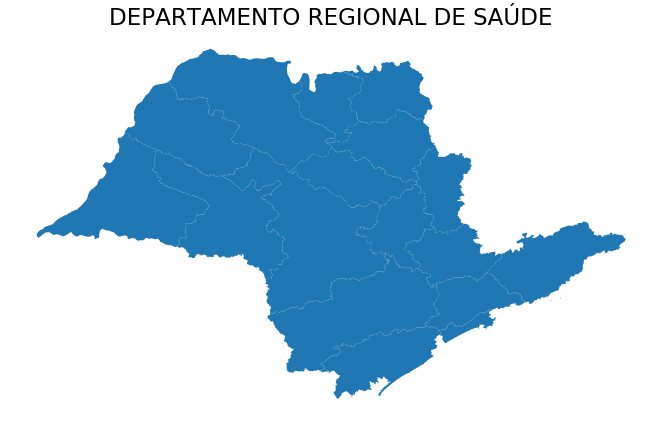

In [45]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.set_title('DEPARTAMENTO REGIONAL DE SAÚDE',fontsize=23)
df_drs.plot(ax = ax)
# ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

![](http://www.saude.sp.gov.br/resources/ses/institucional/drs/mapa_departamentos_regionais_de_saude_b.jpg)

In [46]:
df_drs.head()

,ID,DEPARTAMENTO REGIONAL DE SAÚDE,geometry
0,3501,GRANDE SÃO PAULO,POLYGON ((-45.96146250967615 -23.4965595185349...
1,3502,ARAÇATUBA,"POLYGON ((-49.84272723928282 -21.354860126361,..."
2,3503,ARARAQUARA,POLYGON ((-48.04441212682702 -22.0727468493557...
3,3504,BAIXADA SANTISTA,(POLYGON ((-46.90199030673633 -24.388091815525...
4,3505,BARRETOS,POLYGON ((-48.58070526823429 -21.1652107759978...


In [ ]:
# mask= df_drs['DEPARTAMENTO REGIONAL DE SAÚDE'] == drs

In [299]:
# mask = (df_plot_iam['ANO'] == 2000) & (df_plot_iam['REGIÃO DE SAÚDE']=='')

In [302]:
# for drs in df_drs['DEPARTAMENTO REGIONAL DE SAÚDE'].unique():
#     mask= df_drs['DEPARTAMENTO REGIONAL DE SAÚDE'] == drs
#     print(drs)
#     fig = plt.figure(figsize=(10,10))
#     ax  = fig.add_subplot(1,1,1)
#     ax.set_title('{}'.format(drs))
    
#     df_drs[mask].plot(ax=ax)

In [162]:
# import necessary libraries
import geopandas
import shapely
import shapefile
import plotly
from plotly.figure_factory._county_choropleth import create_choropleth
import xlrd
# Check your version
print(plotly.__version__, geopandas.__version__,shapely.__version__,shapefile.__version__)
# Data
df_sample = pd.read_excel('popdata.xlsx') # Read in your data
values = df_sample['Change'].tolist() # Read in the values contained within your file
fips = df_sample['FIPS'].tolist() # Read in FIPS Codes

colorscale = ["#171c42","#223f78","#1267b2","#4590c4","#8cb5c9","#b6bed5","#dab2be",
              "#d79d8b","#c46852","#a63329","#701b20","#3c0911"]

endpts = list(np.linspace(-75, 75, len(colorscale) - 1)) # Identify a suitable range for your data

fig = create_choropleth(
   fips=fips, values=values, colorscale=colorscale, show_state_data=True, binning_endpoints=endpts, # If your values is a list of numbers, you can bin your values into half-open intervals
    county_outline={'color': 'rgb(255,255,255)', 'width': 0.5}, 
    legend_title='% change', title='% Change in disease between 1980-2014'
)
# Plot in offline mode and save plot in your Python script folder
plotly.offline.plot(fig, filename='diseasechange.html')

In [171]:
mask = df_dci_reg['ANO'] == 2000

df_dci_reg[mask].head(30)

,REGIÃO DE SAÚDE,ANO,TAXA PAD WHO POP TOTAL,SE TAXA PAD WHO POP TOTAL,Mean(TAXA PAD WHO POP TOTAL),Mean(SE TAXA PAD WHO POP TOTAL),Z-SCORE
0,35011 ALTO DO TIETÊ,2000,98.795404,2.666624,68.461637,5.560863,5.454867
19,35012 FRANCO DA ROCHA,2000,105.172852,6.608178,68.461637,5.560863,6.601712
38,35013 MANANCIAIS,2000,100.225081,4.683068,68.461637,5.560863,5.711963
57,35014 ROTA DOS BANDEIRANTES,2000,105.509296,3.392894,68.461637,5.560863,6.662214
76,35015 GRANDE ABC,2000,103.971154,2.426862,68.461637,5.560863,6.385613
95,35016 SÃO PAULO,2000,105.205526,1.110674,68.461637,5.560863,6.607588
114,35021 CENTRAL DO DRS II,2000,48.096170,4.508755,68.461637,5.560863,-3.662285
133,35022 DOS LAGOS DO DRS II,2000,37.551517,4.696735,68.461637,5.560863,-5.558512
152,35023 DOS CONSÓRCIOS DO DRS II,2000,51.581808,5.062713,68.461637,5.560863,-3.035469
171,35031 CENTRAL DO DRS III,2000,82.305939,6.101790,68.461637,5.560863,2.489596


In [176]:
df_test = gpd.read_file('asd.json')


In [179]:
df_test.shape

(10, 2)

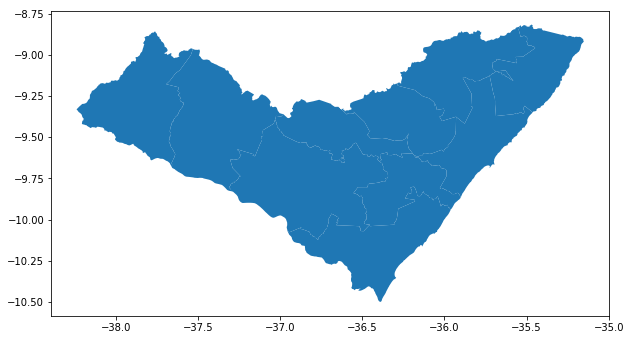

In [178]:
df_test.plot(figsize=(10,10))

In [73]:
df_maps.shape

(645, 4)

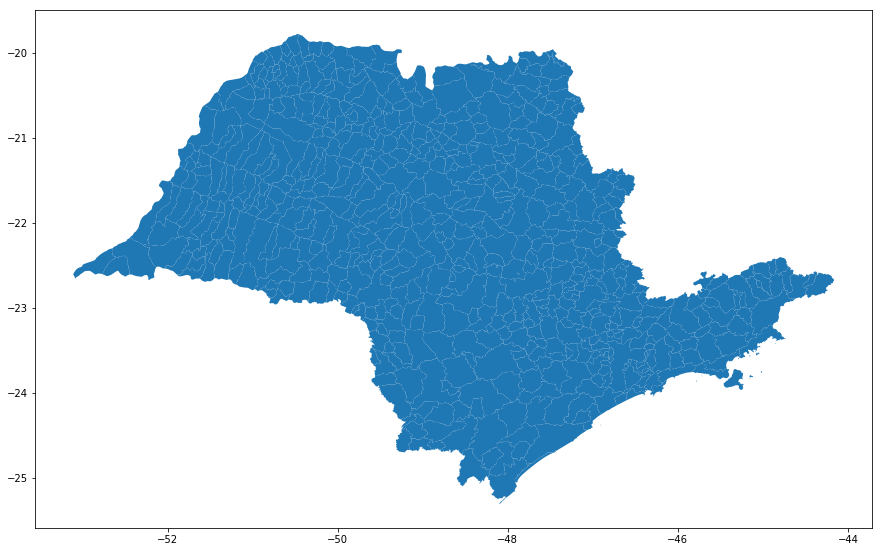

In [90]:

df_maps.plot(figsize=(15,15))

In [5]:

sp_json = json.load(open('{}/sp.json'.format(RAW_PATH)),encoding='latin-1')

In [6]:
sp_json.keys()

dict_keys(['type', 'features'])

In [28]:
sp_json['features'][0]

{'type': 'Feature',
 'properties': {'id': '3500105',
  'name': 'Adamantina',
  'description': 'Adamantina'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-51.0578686748, -21.3988835488],
    [-51.0536454977, -21.4046228386],
    [-51.0450043489, -21.4037238276],
    [-51.045439432, -21.4063589008],
    [-51.0397224364, -21.4067760488],
    [-51.0330880762, -21.408863112],
    [-51.0247100808, -21.4208663742],
    [-51.0245845013, -21.4263462599],
    [-51.0033347502, -21.4385388237],
    [-50.9925874583, -21.4367999015],
    [-50.9911744426, -21.4418090183],
    [-50.9772464698, -21.4526305135],
    [-50.9674002039, -21.4750044331],
    [-50.9701364325, -21.4791879543],
    [-50.9651317696, -21.4838230857],
    [-50.9672264355, -21.4912547321],
    [-50.9644621647, -21.5045943621],
    [-50.9684617375, -21.5150857178],
    [-50.9639572448, -21.5215964229],
    [-50.9656099653, -21.5382668569],
    [-50.96736118, -21.5431056598],
    [-50.9739312904, -21.5459116694],
    [-50.97